In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

In [2]:
env = gym.make("CartPole-v0")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical

class QualityNet(nn.Module):
    '''Takes a state and returns probabilities for each action.'''
    def __init__(self):
        super().__init__()
        self.epsilon = 1
        self.epsilon_decay = 0.9995
        self.min_epsilon = 0.05
        self.layer_1 = nn.Linear(4, 64)
        self.layer_2 = nn.Linear(64, 2)
        #self.layer_1 = nn.Linear(4, 2)
    def forward(self, state):
        x = torch.Tensor(state)
        x = F.relu(self.layer_1(x))
        x = self.layer_2(x)
        #x = self.layer_1(x)
        #x = self.layer_2(x)
        return x
    def policy(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(env.action_space.n)
        else:
            action = torch.max(Q(state), dim=0)[1].item()
        return action
        #return int(state[3]-state[1] + state[2]-state[0] > 0)
    def reduce_policy_randomness(self):        
        self.epsilon *= self.epsilon_decay
        if (self.epsilon < self.min_epsilon):
            self.epsilon = self.min_epsilon
Q = QualityNet()

In [4]:
from torch import optim
from collections import namedtuple
import random

class MemoryBank():
    def __init__(self):
        self.memories = []
        self.replay_batch_n = 200
        self.memory_size = self.replay_batch_n*50
        self.gamma = 0.99
        self.learning_rate = 0.1
        self.learning_rate_decay = 0.9996
        self.min_learning_rate = 0.001
        self.optimizer = optim.Adam(Q.parameters(), lr=self.learning_rate)
        self.loss_function = nn.MSELoss()
    def reduce_learning_rate(self):        
        self.learning_rate *= self.learning_rate_decay
        if (self.learning_rate < self.min_learning_rate):
            self.learning_rate = self.min_learning_rate
        self.optimizer = optim.Adam(Q.parameters(), lr=self.learning_rate)
    def remember(self, memory):
        self.memories.append(memory)
        if len(self.memories) > self.memory_size: self.memories.pop(0)
    def recall(self, n_memories):
        memory_batch = random.sample(self.memories, n_memories)
        return list(map(list, zip(*memory_batch)))
    def recall_and_learn(self):
        if len(self.memories) < self.memory_size: return
        state_batch, action_batch, reward_batch, new_state_batch, game_over_batch = self.recall(self.replay_batch_n)
        old_quality_batch = Q(state_batch)[list(range(self.replay_batch_n)), action_batch]
        game_not_over_batch = [1-i for i in game_over_batch]
        new_quality_batch = torch.Tensor(reward_batch) + torch.Tensor(game_not_over_batch)*self.gamma*torch.max(Q(new_state_batch), dim=1)[0]
        #print("OLD", old_quality_batch)
        #print("NEW", new_quality_batch)
        loss = self.loss_function(old_quality_batch, new_quality_batch)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
memory = MemoryBank()

In [5]:
training_history = []
frames = []
frame_info = []
n_games = 20000
new_frames = []
new_frame_info = []
#target_Q = copy.deepcopy(Q)

for n in range(n_games):
    game_over = False
    state = env.reset()
    game_reward = 0
    while not game_over:
        action = Q.policy(state)
        new_state, reward, game_over, _ = env.step(action)
        memory.remember((state, action, reward, new_state, game_over))
        state = new_state
        game_reward += reward
        if (n+1)%1000 == 0:
            new_frames.append(env.render(mode='rgb_array'))
            new_frame_info.append((state, action, reward, new_state, game_over, Q(state)))
    for _ in range(5):
        memory.recall_and_learn()
    memory.reduce_learning_rate()
    Q.reduce_policy_randomness()
    training_history.append([game_reward, Q.epsilon, memory.learning_rate])
    if (n+1)%1000 == 0:
        frames.append(new_frames)
        new_frames = []
        frame_info.append(new_frame_info)
        new_frame_info = []
        #target_Q = copy.deepcopy(Q)
        average_score = np.average(np.array(training_history)[:,0][-200:])
        if (average_score >= 195): break
        print(f"Finished playing {n+1} games. Average score of last 200 games was {average_score:.2f}.")

Finished playing 1000 games. Average score of last 200 games was 16.35.
Finished playing 2000 games. Average score of last 200 games was 56.82.
Finished playing 3000 games. Average score of last 200 games was 55.28.
Finished playing 4000 games. Average score of last 200 games was 46.92.
Finished playing 5000 games. Average score of last 200 games was 53.41.
Finished playing 6000 games. Average score of last 200 games was 67.54.
Finished playing 7000 games. Average score of last 200 games was 87.08.
Finished playing 8000 games. Average score of last 200 games was 33.81.
Finished playing 9000 games. Average score of last 200 games was 103.36.
Finished playing 10000 games. Average score of last 200 games was 113.31.
Finished playing 11000 games. Average score of last 200 games was 91.88.
Finished playing 12000 games. Average score of last 200 games was 105.66.
Finished playing 13000 games. Average score of last 200 games was 105.61.
Finished playing 14000 games. Average score of last 200 

Game reward


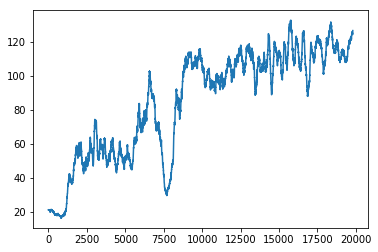

Policy epsilon


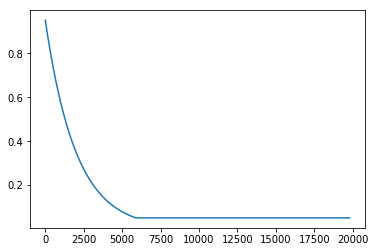

Learning rate


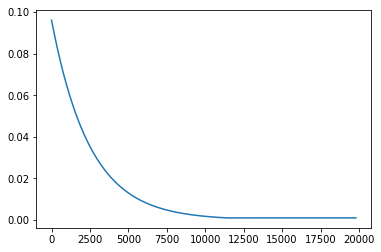

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

training_history = np.array(training_history)
average_over = 200
print("Game reward")
plt.plot(np.convolve(training_history[:,0], np.ones((average_over,))/average_over, mode='valid'))
plt.show()
print("Policy epsilon")
plt.plot(np.convolve(training_history[:,1], np.ones((average_over,))/average_over, mode='valid'))
plt.show()
print("Learning rate")
plt.plot(np.convolve(training_history[:,2], np.ones((average_over,))/average_over, mode='valid'))
plt.show()

In [7]:
def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

def show_frameset(frameset):
    print("state, quality, action")
    for info in frame_info[frameset]:
        print(info[0], info[5].detach().numpy(), info[1])

    display_frames_as_gif(frames[frameset])

state, quality, action
[ 0.03665678  0.1845217   0.01856843 -0.26954976] [27.462824 27.419514] 1
[ 0.04034721 -0.01086024  0.01317743  0.02893144] [27.526936 27.537647] 0
[ 0.04013001  0.18407028  0.01375606 -0.25956491] [27.555735 27.514744] 1
[ 0.04381141 -0.01124532  0.00856476  0.03742493] [27.612179 27.624485] 0
[ 0.04358651  0.18375277  0.00931326 -0.25254347] [27.635271 27.596066] 1
[ 0.04726156 -0.01150092  0.00426239  0.04306242] [27.685066 27.698502] 0
[ 0.04703154  0.18355965  0.00512364 -0.24827264] [27.703167 27.665257] 1
[ 0.05070274 -0.0116351   0.00015819  0.04602198] [27.747149 27.761272] 0
[ 0.05047003  0.18348459  0.00107863 -0.24661103] [27.760832 27.72377 ] 1
[ 0.05413973 -0.01165275 -0.00385359  0.04641193] [27.79968  27.814064] 0
[ 0.05390667  0.18352424 -0.00292535 -0.24748435] [27.80941 27.77277] 1
[ 0.05757715 -0.01155581 -0.00787504  0.04427442] [27.843658 27.857883] 0
[ 0.05734604  0.18367818 -0.00698955 -0.25088271] [27.849802 27.813168] 1
[ 0.0610196  -0.0


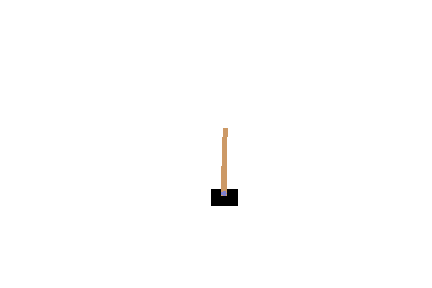
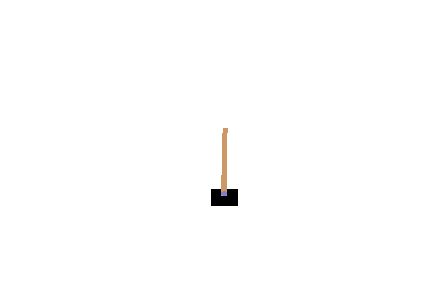
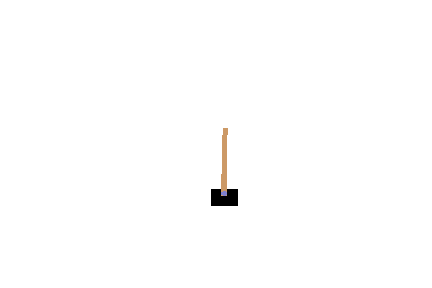
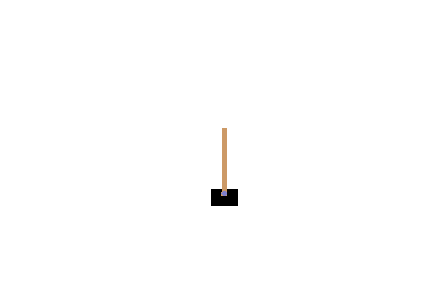
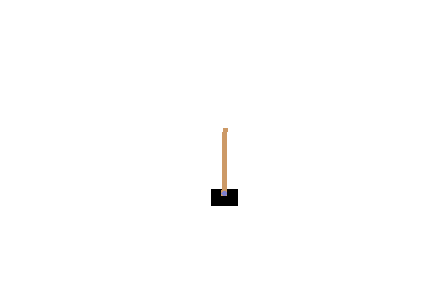
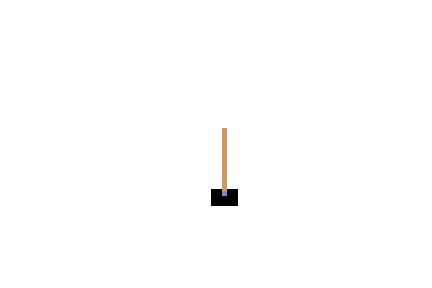
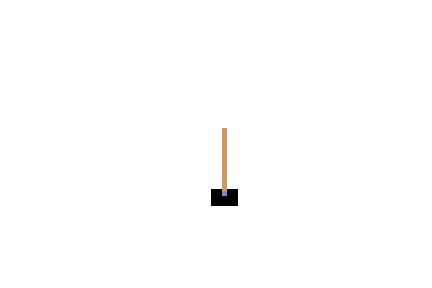
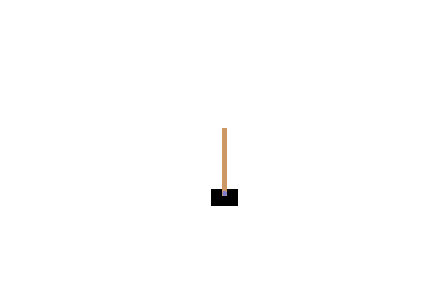
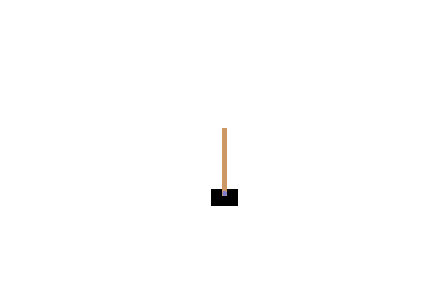
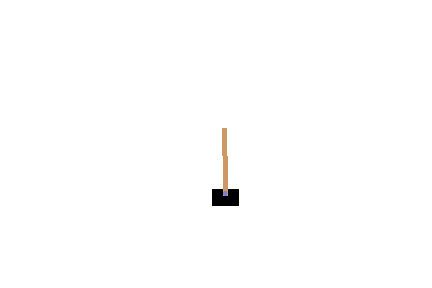
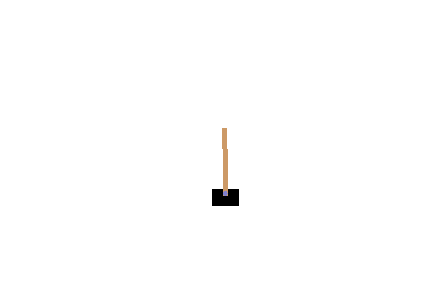
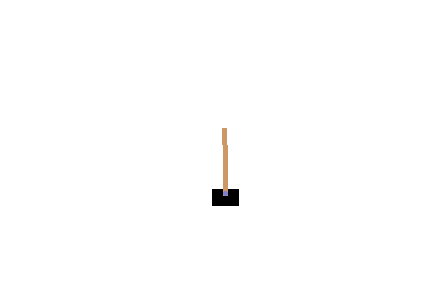
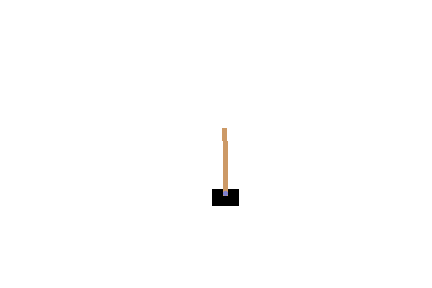
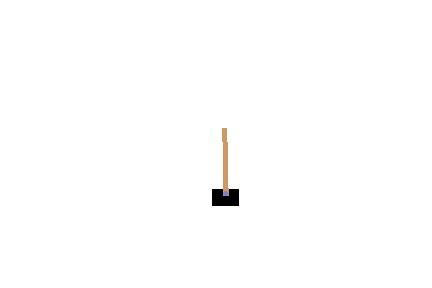
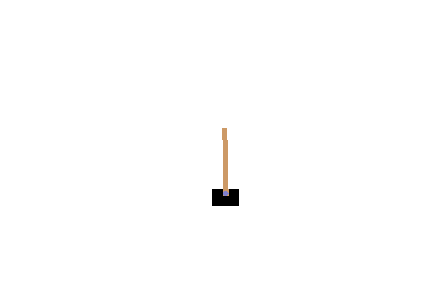
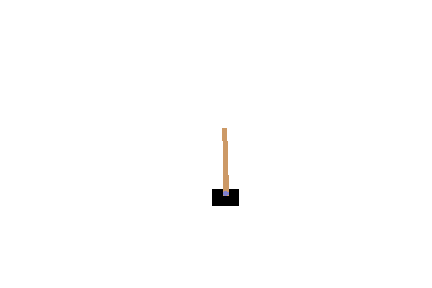
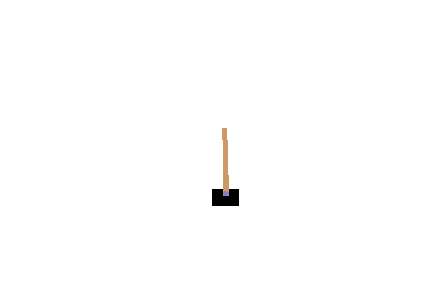
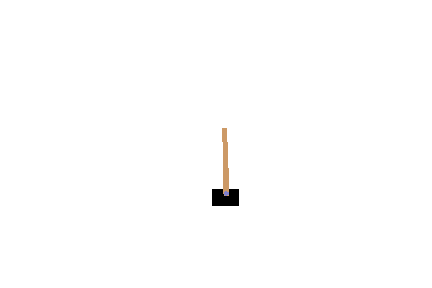
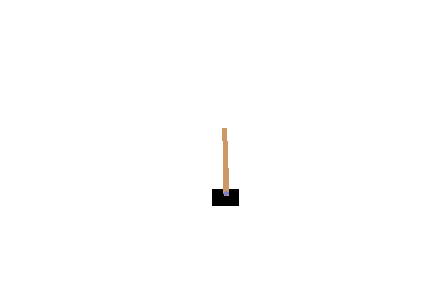
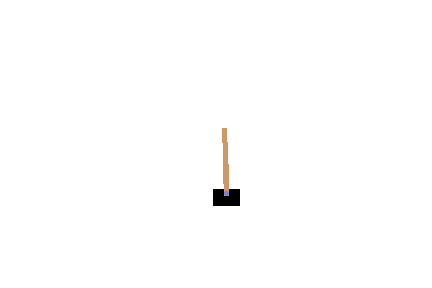
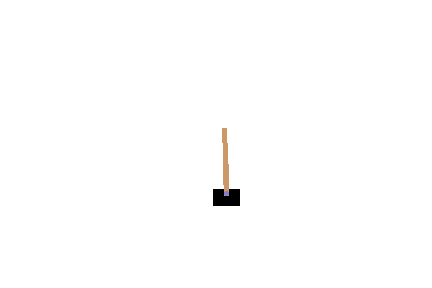
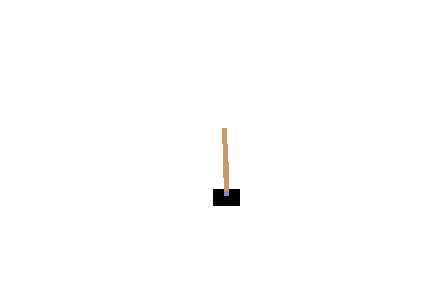
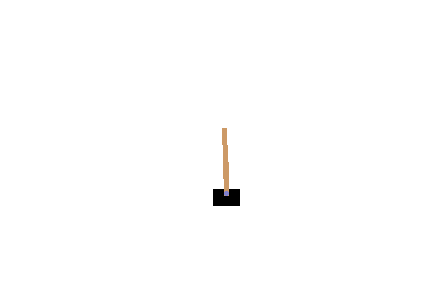
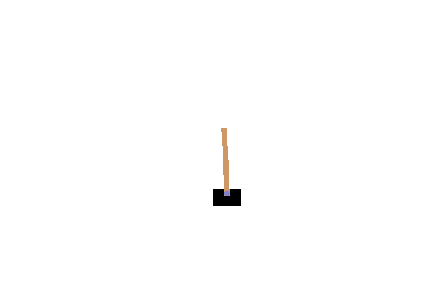
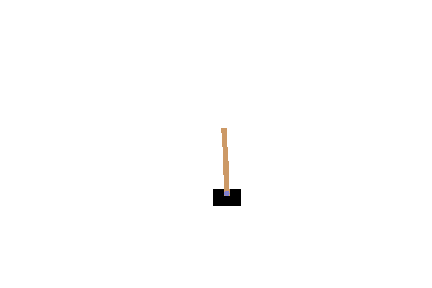
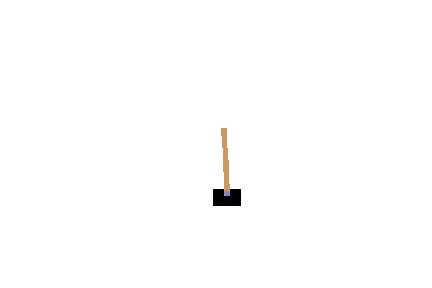
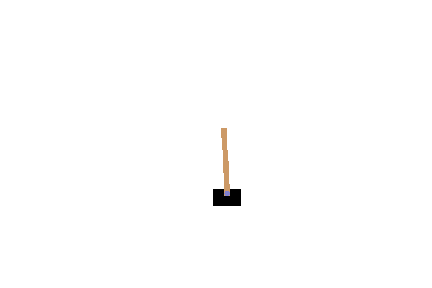
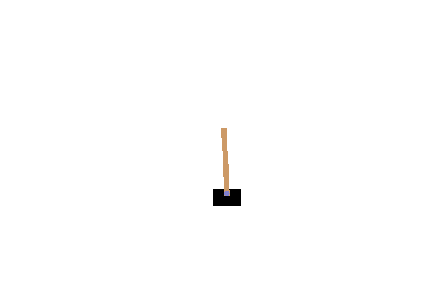
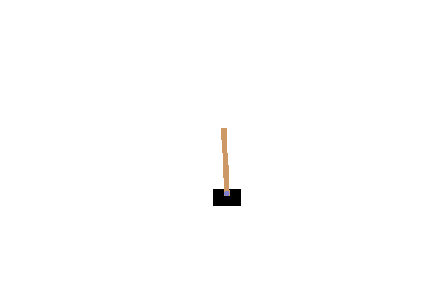
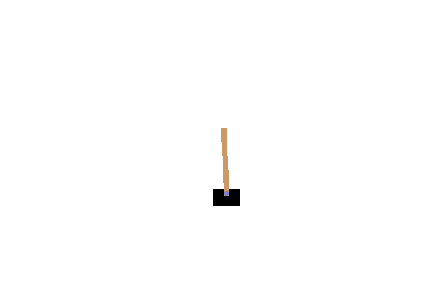
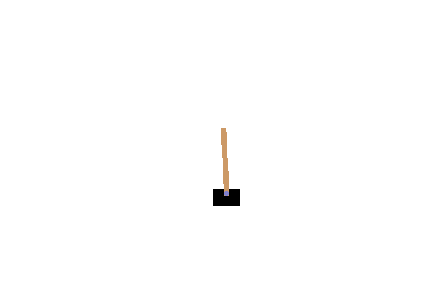
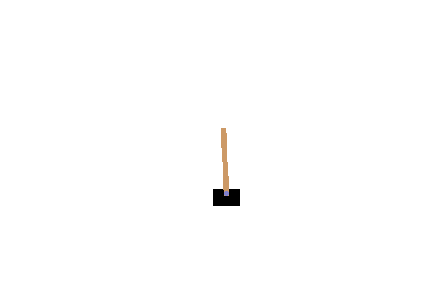
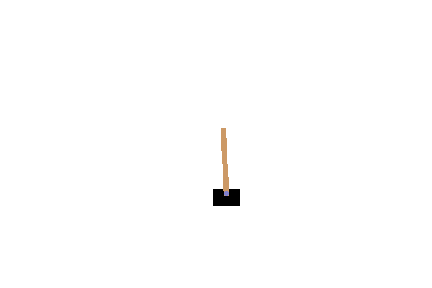
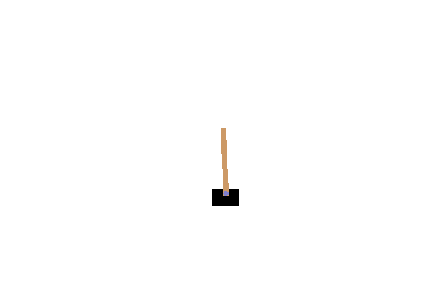
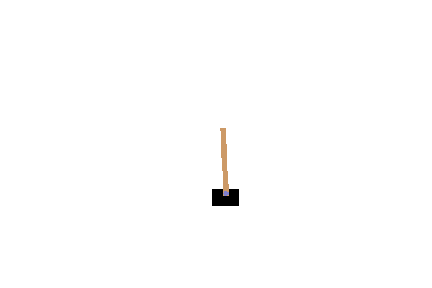
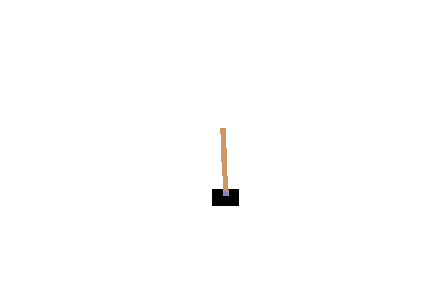
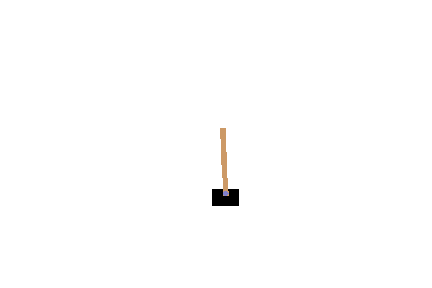
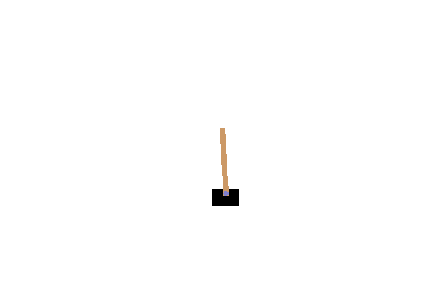
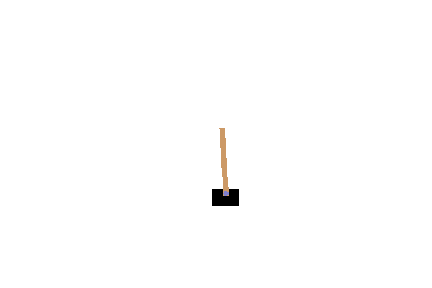
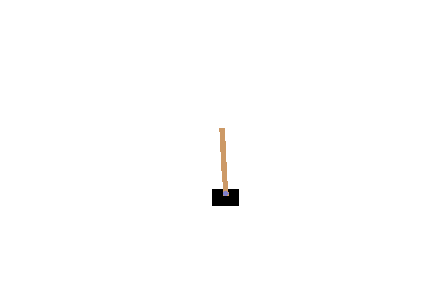
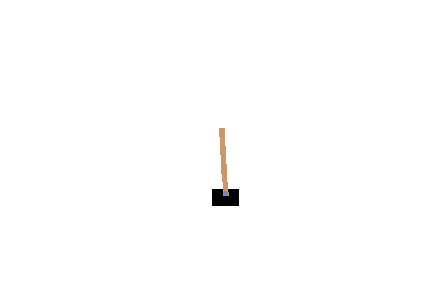
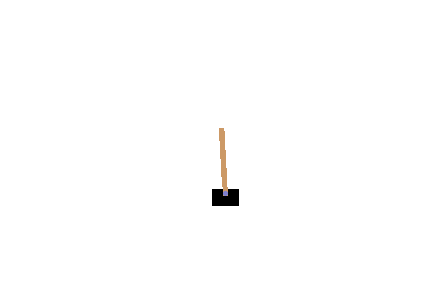
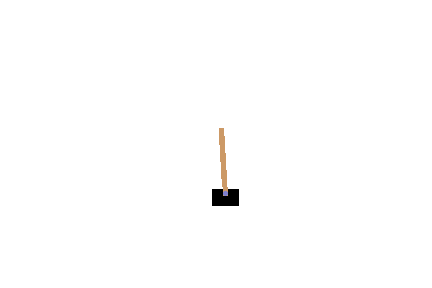
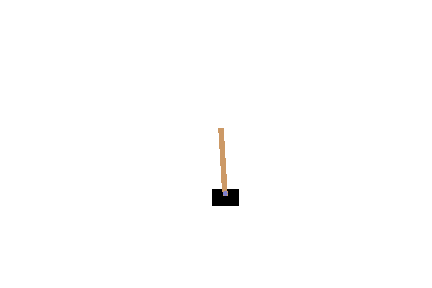
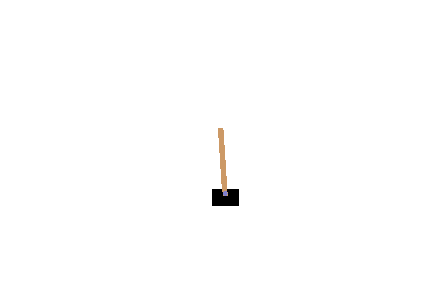
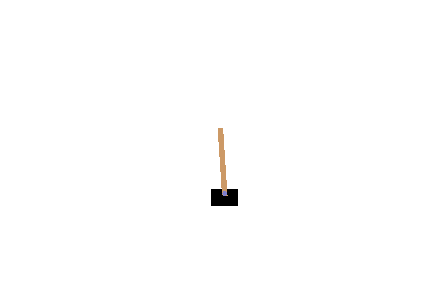
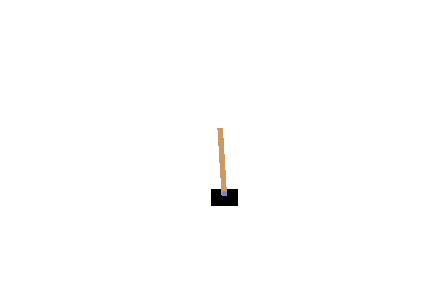
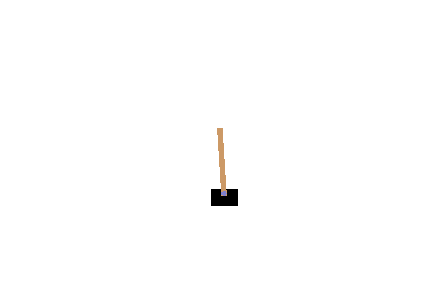
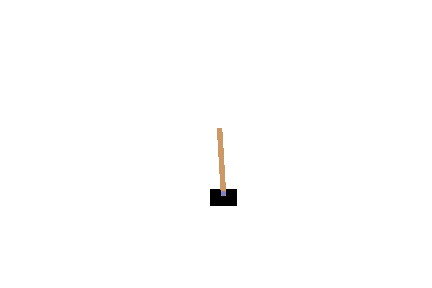
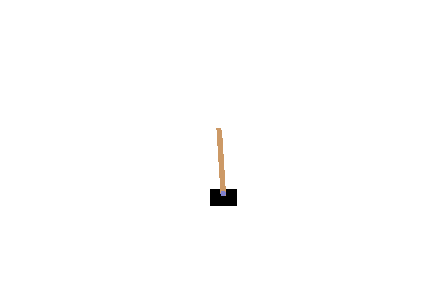
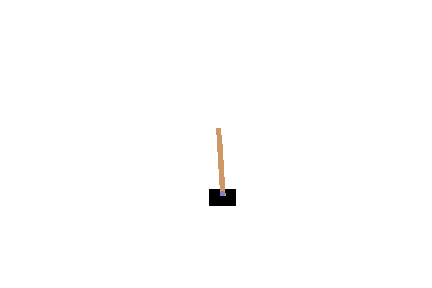
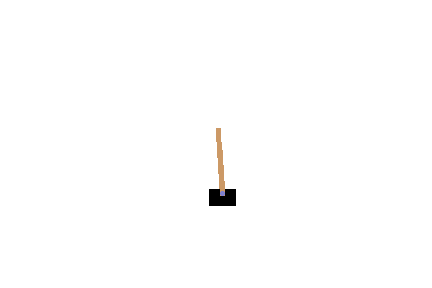
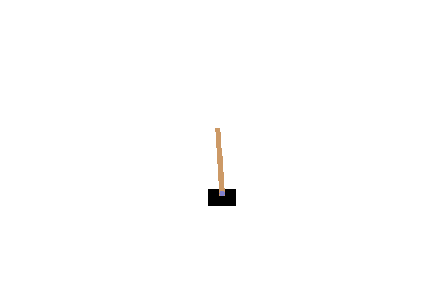
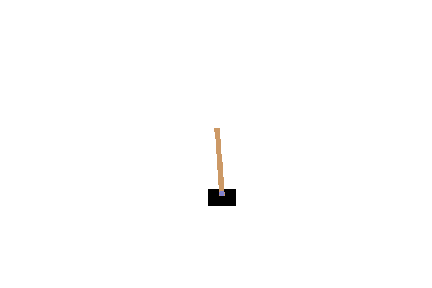
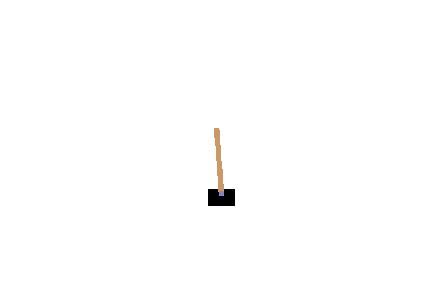
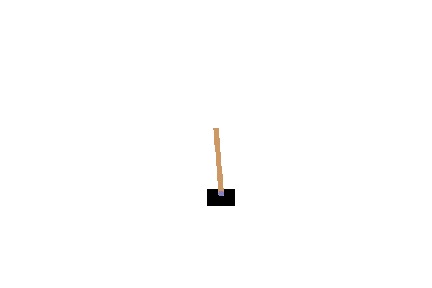
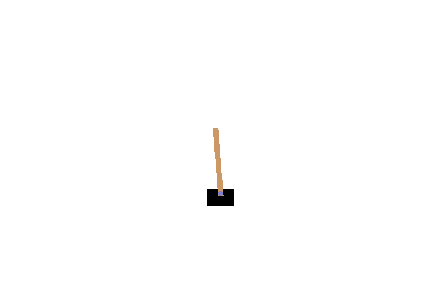
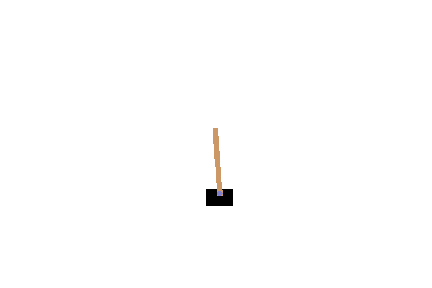
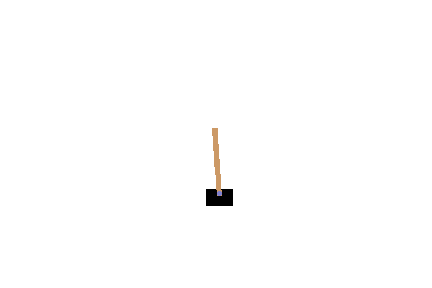
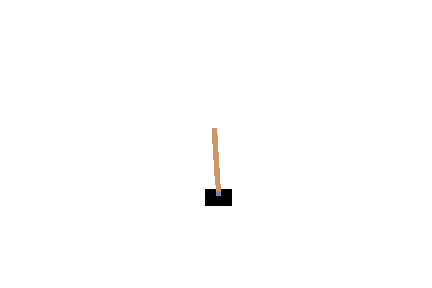
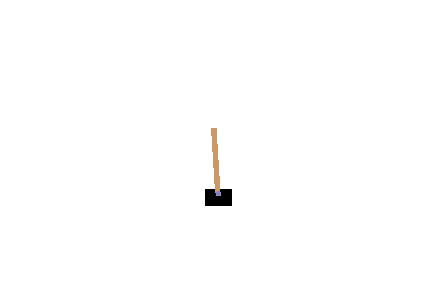
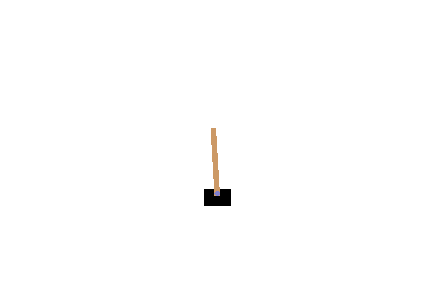
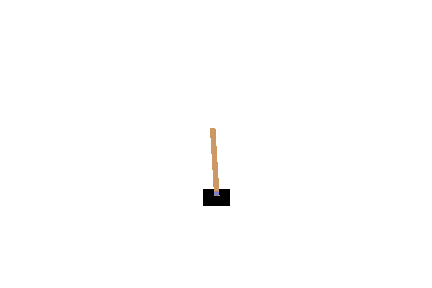
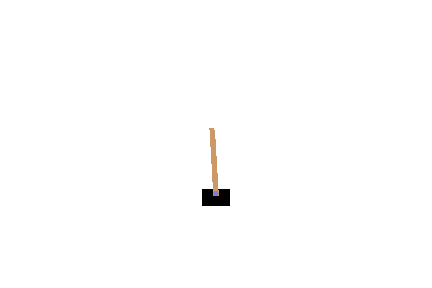
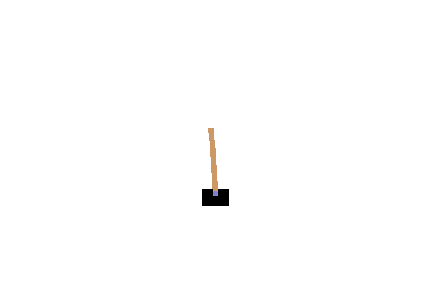
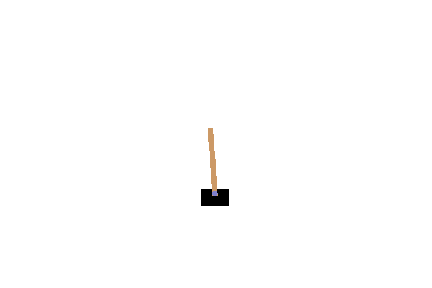
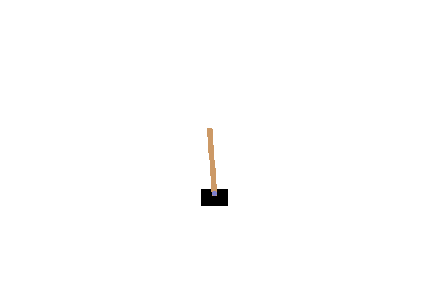
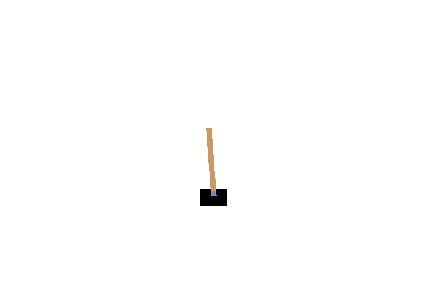
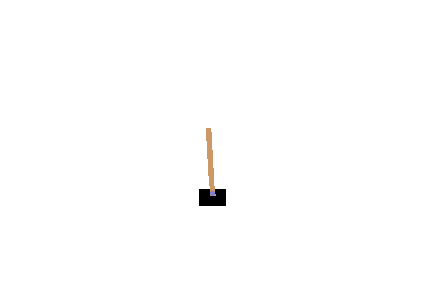
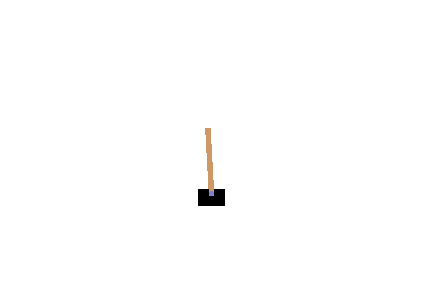
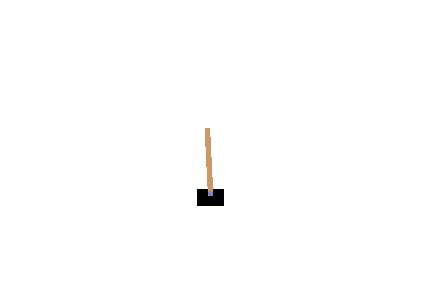
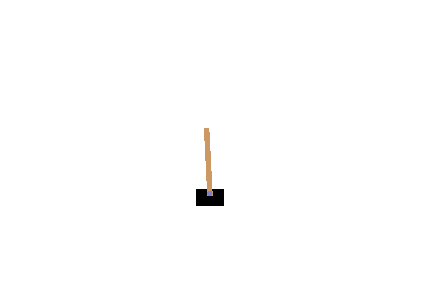
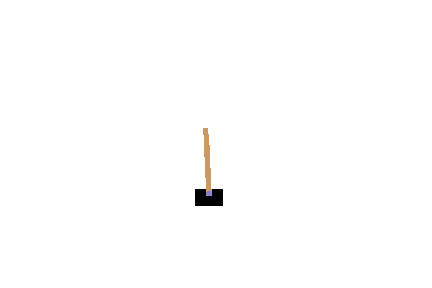
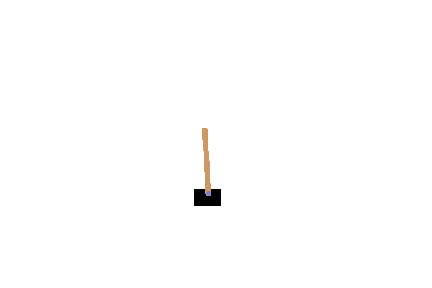
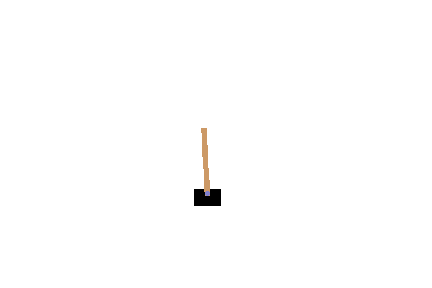
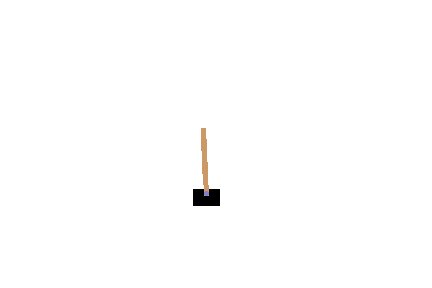
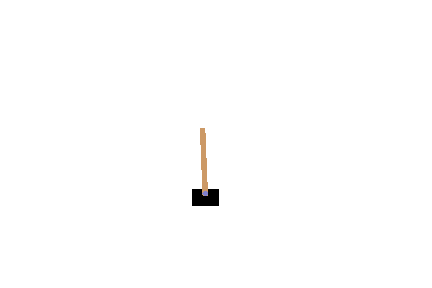
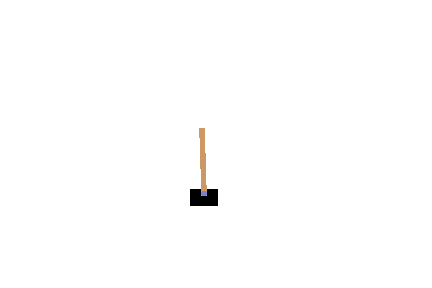
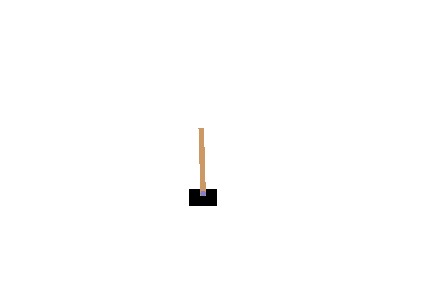
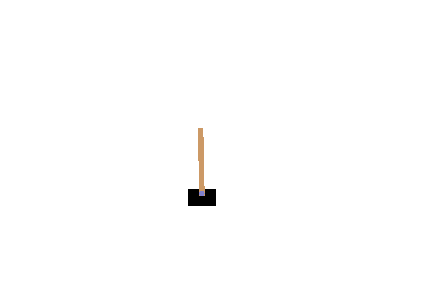
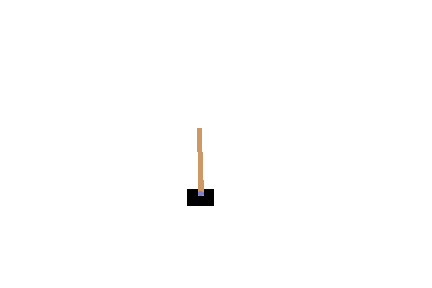
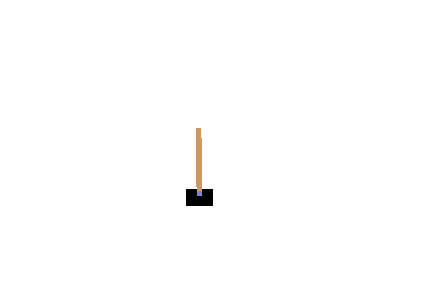
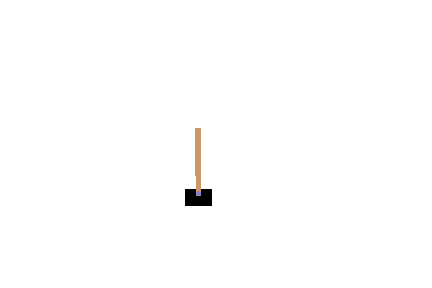
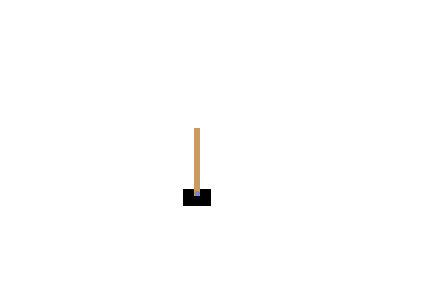
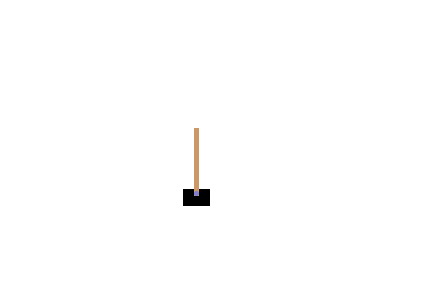
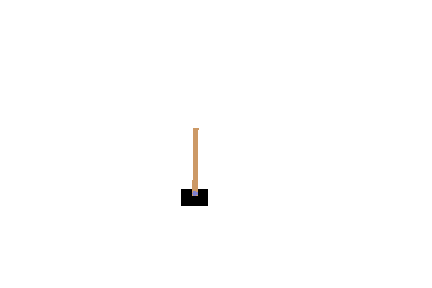
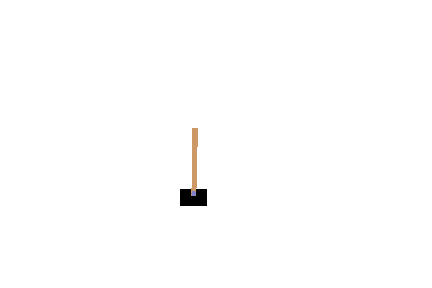
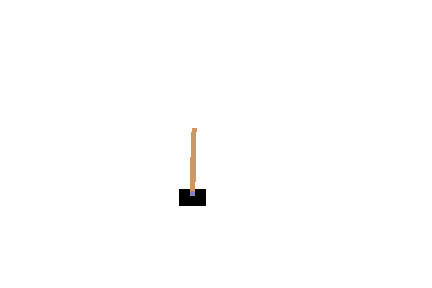
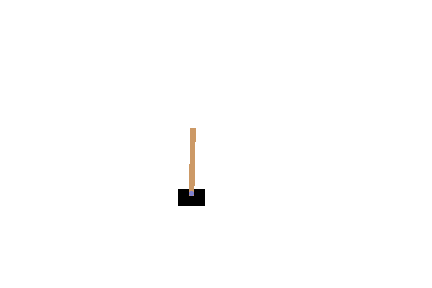
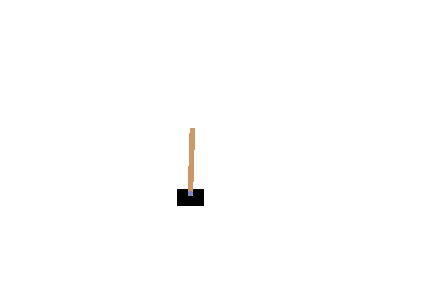
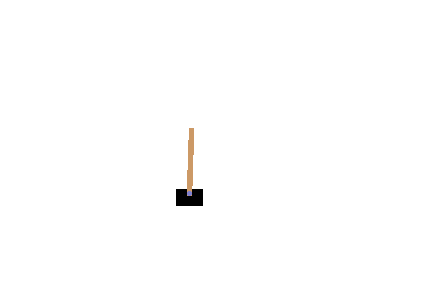
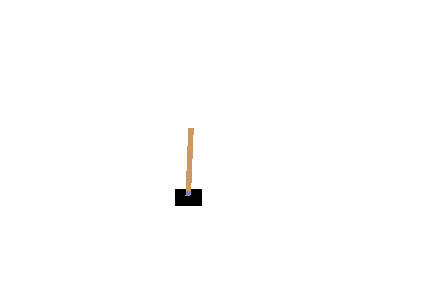
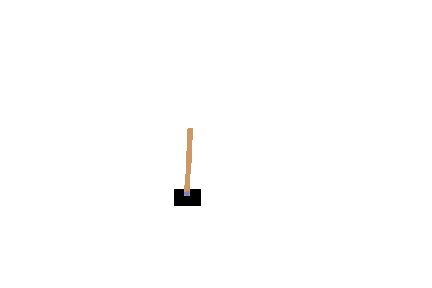
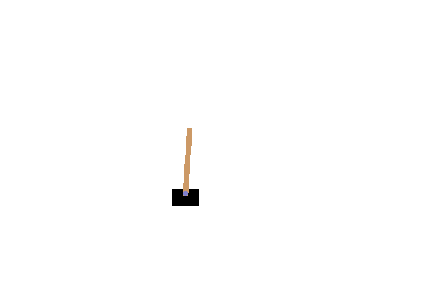
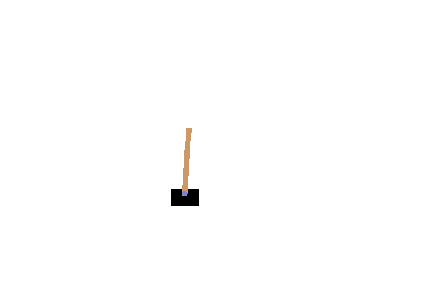
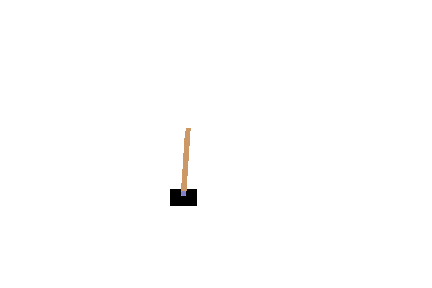
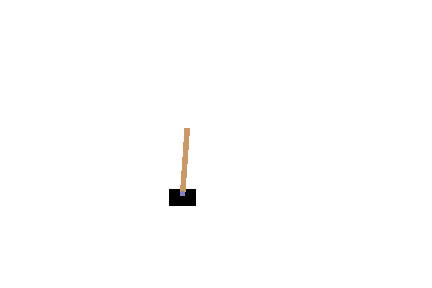
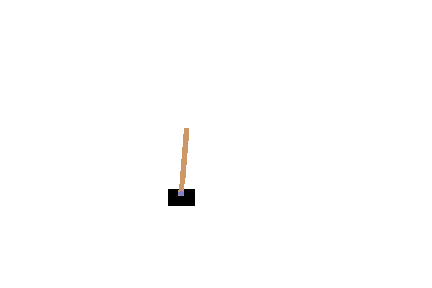
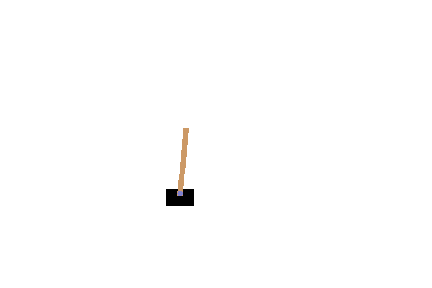
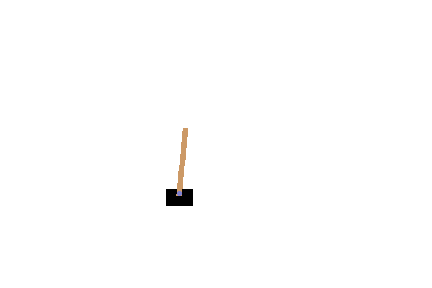
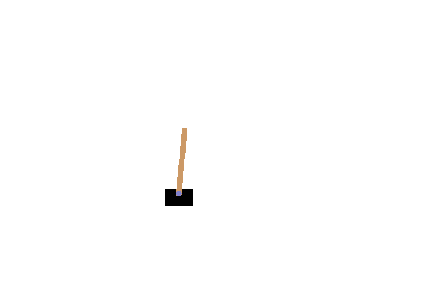
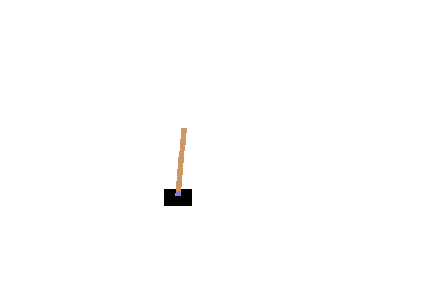
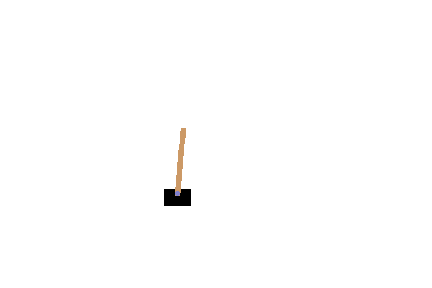
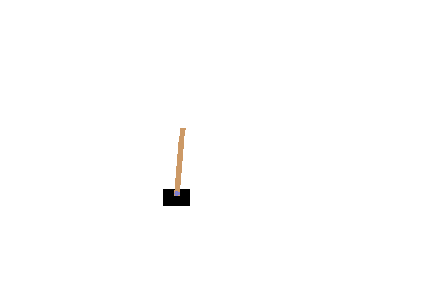
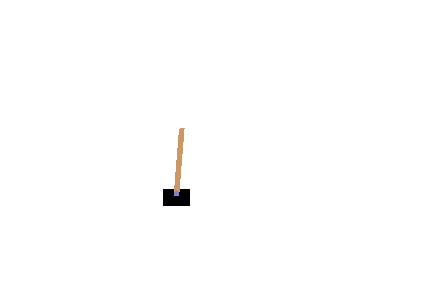
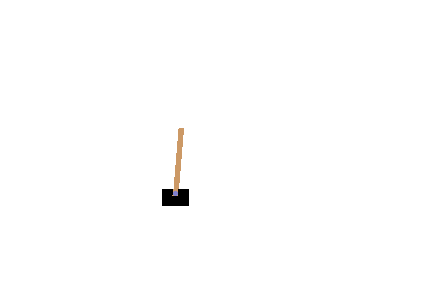
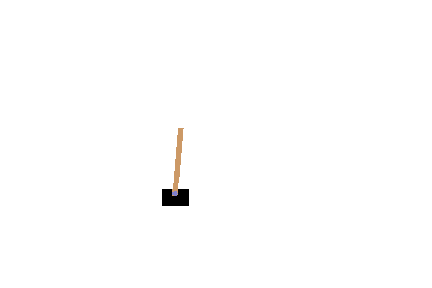
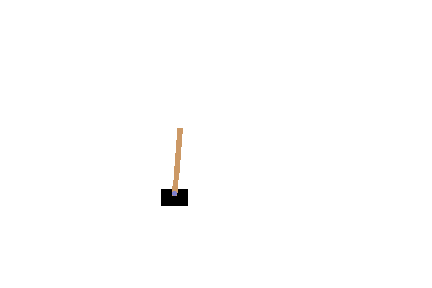
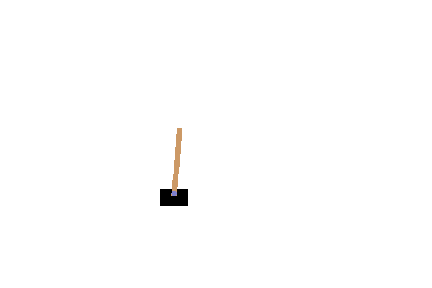
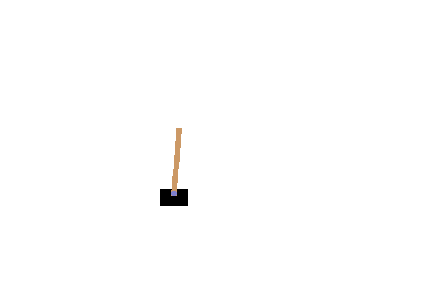
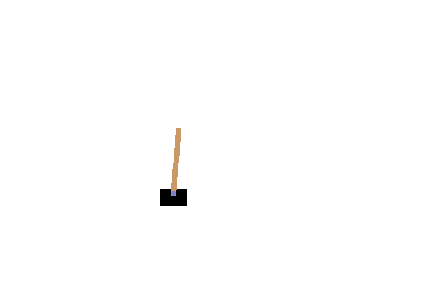
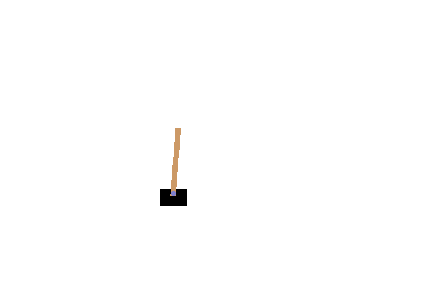
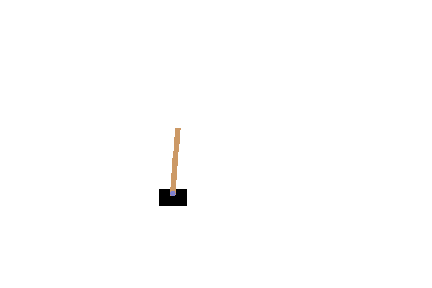
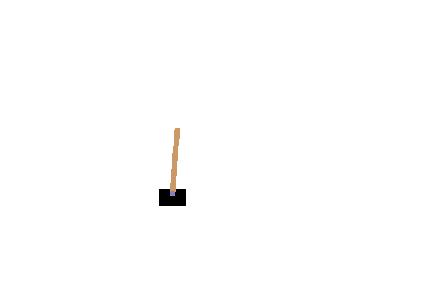
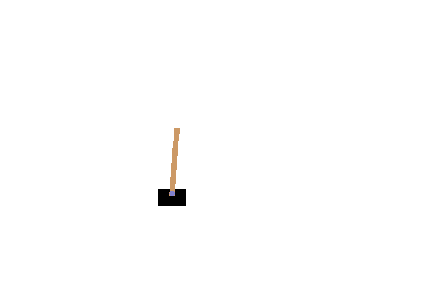
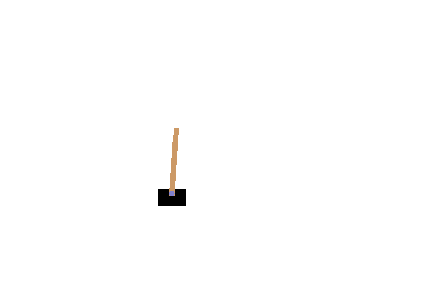
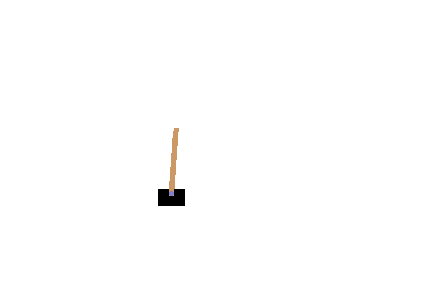
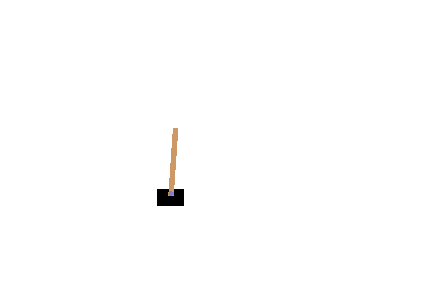
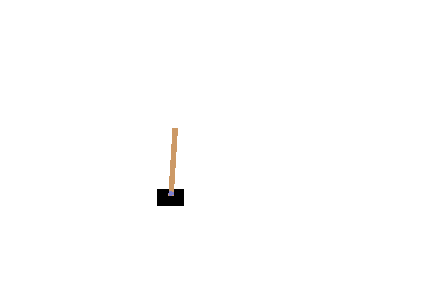
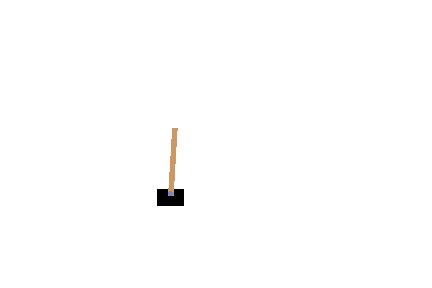
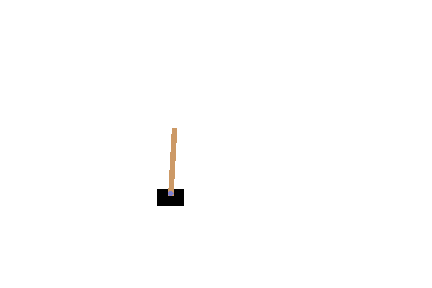
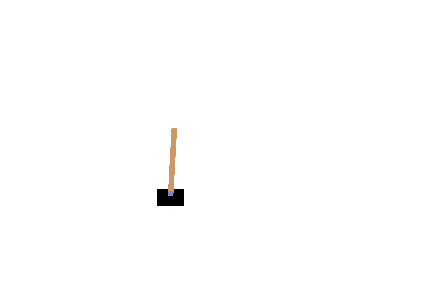
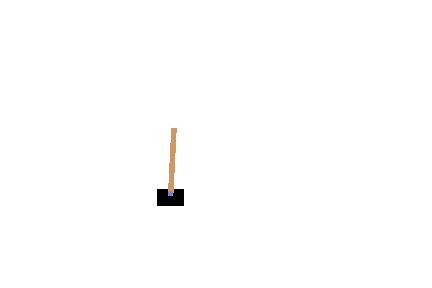
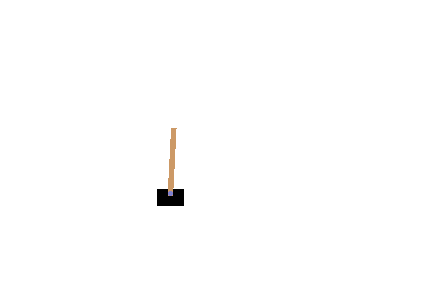
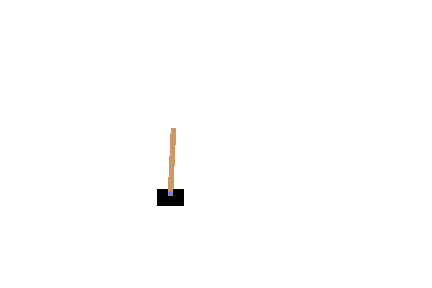
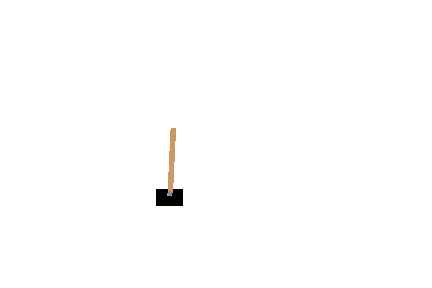
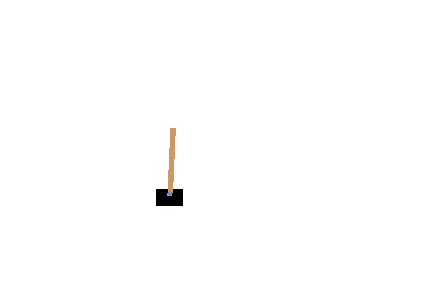
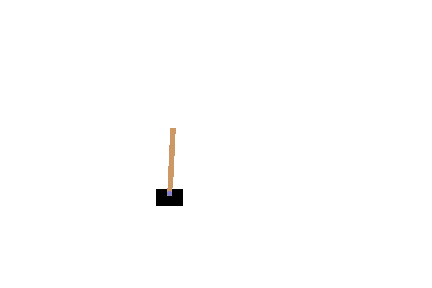
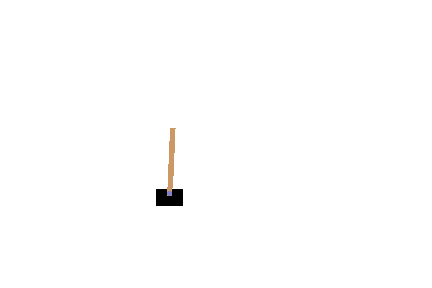
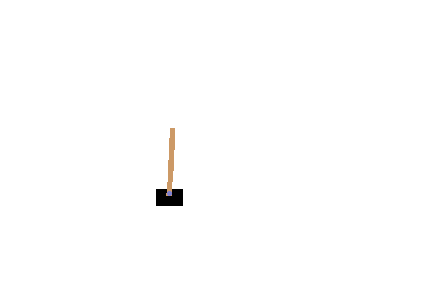
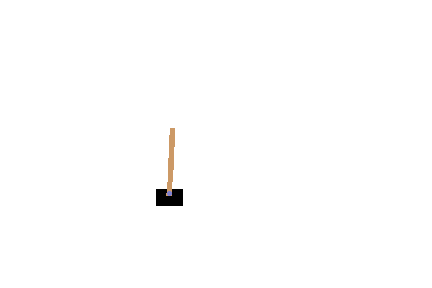
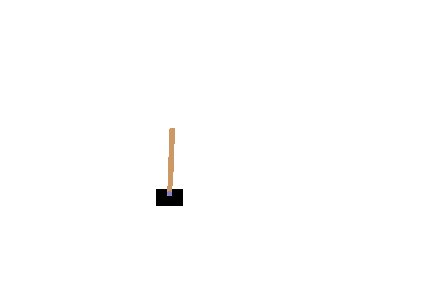
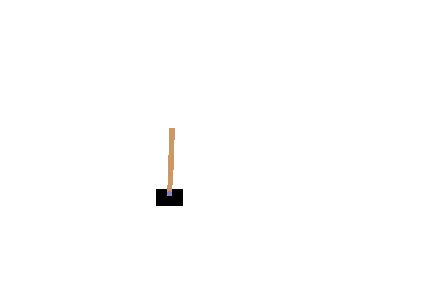
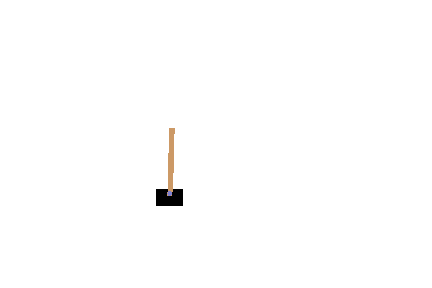
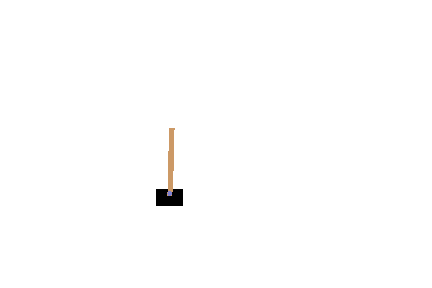
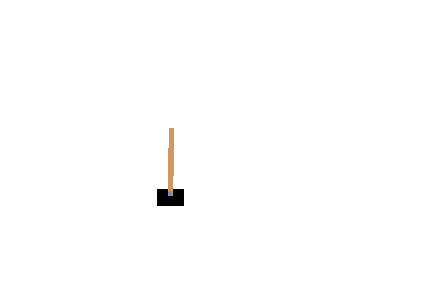
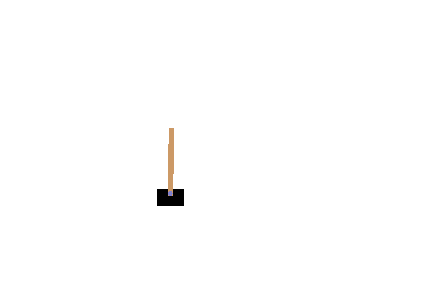
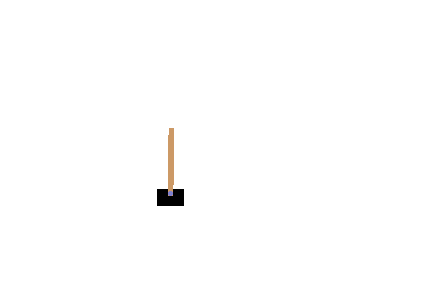
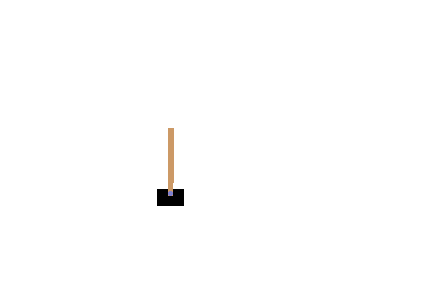
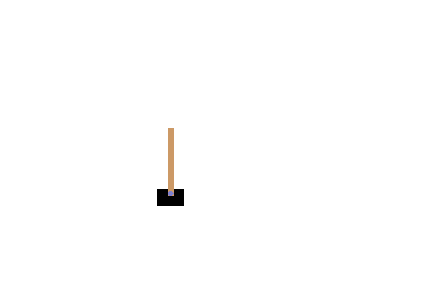
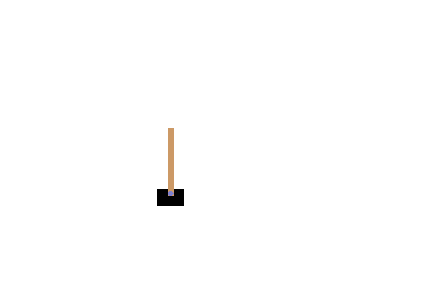
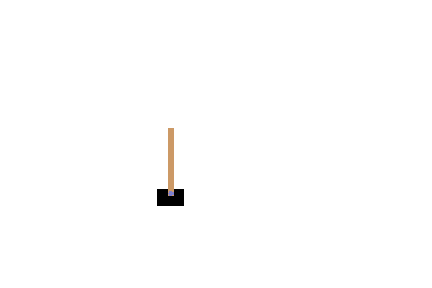
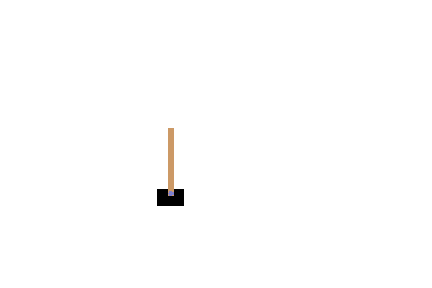
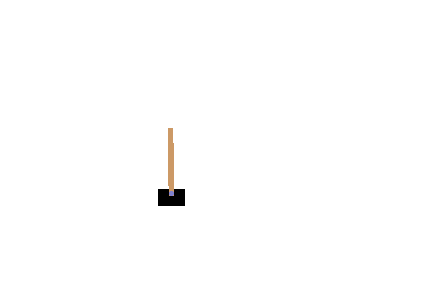
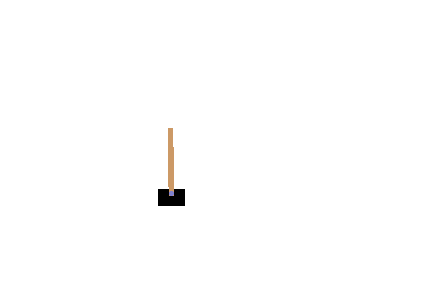
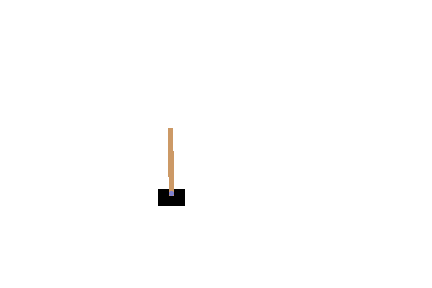
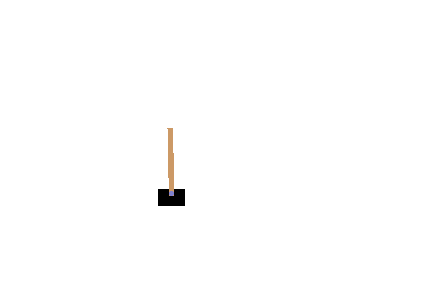
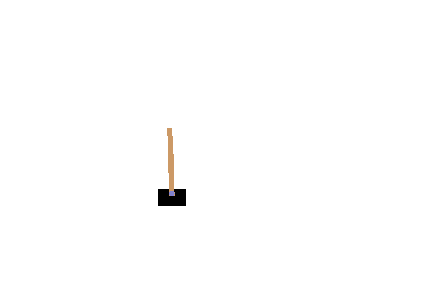
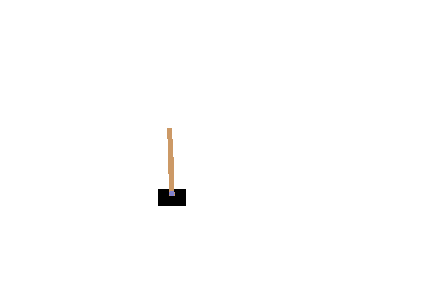
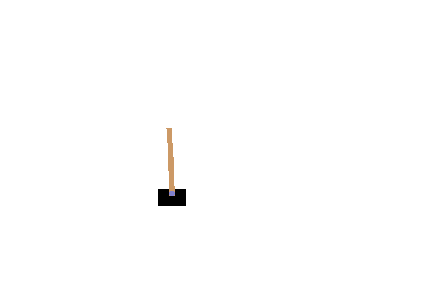
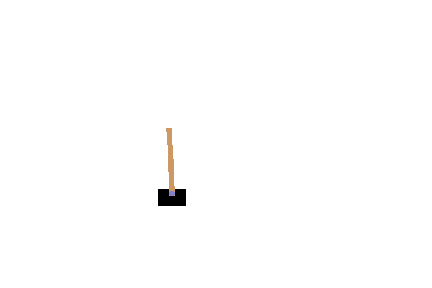
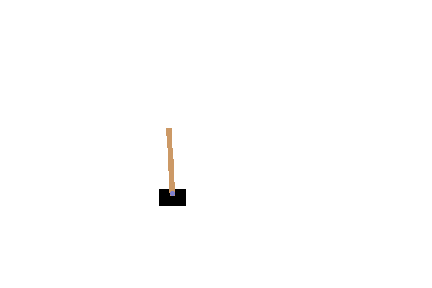
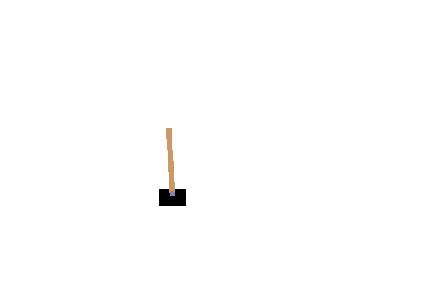
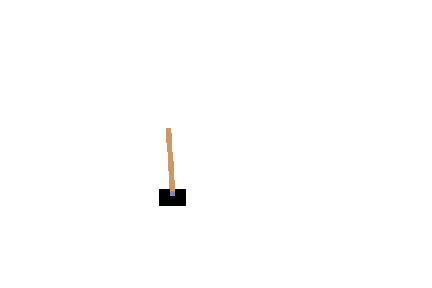
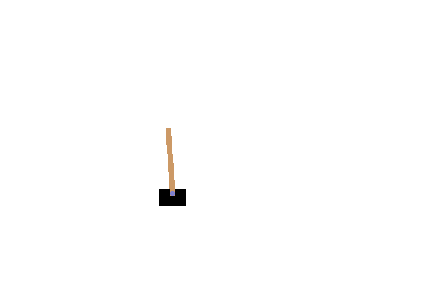
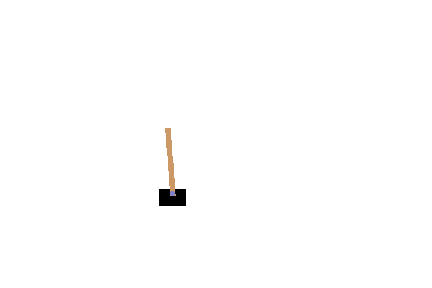
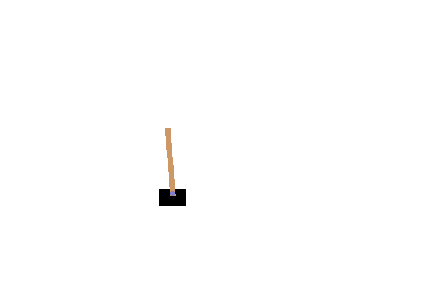
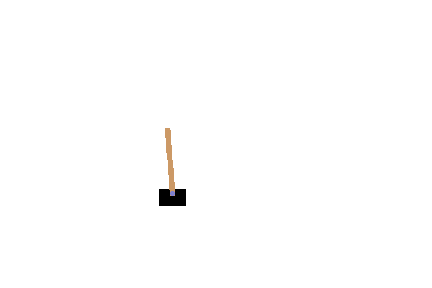
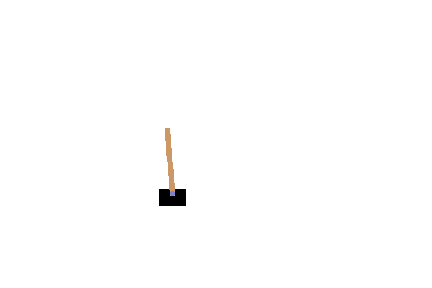
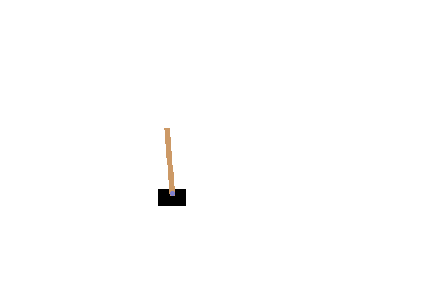
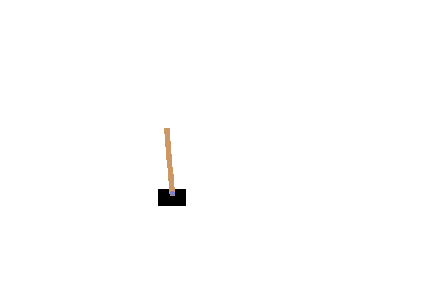
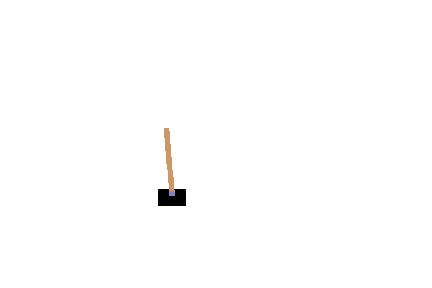
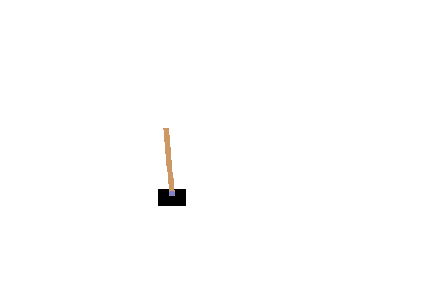
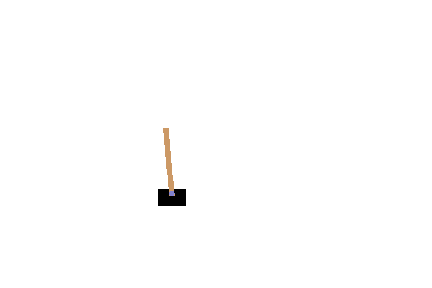
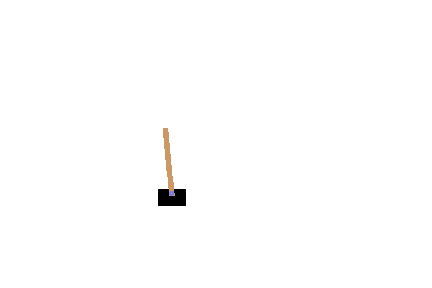
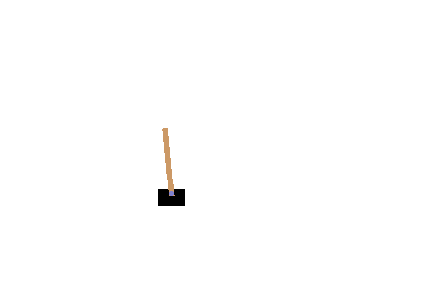
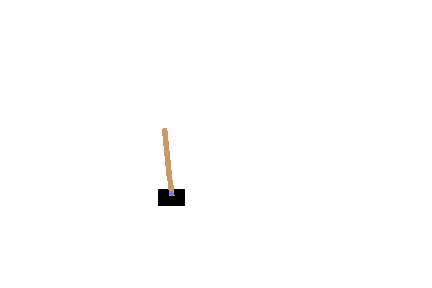
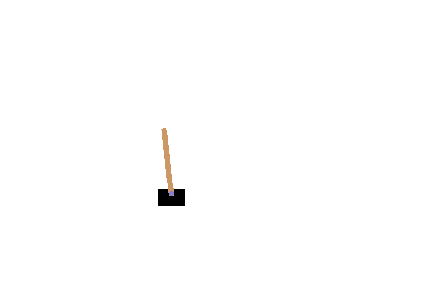
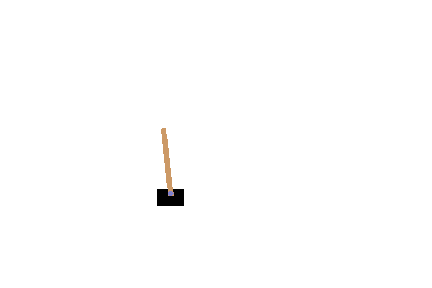
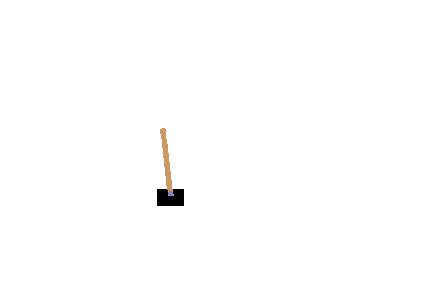
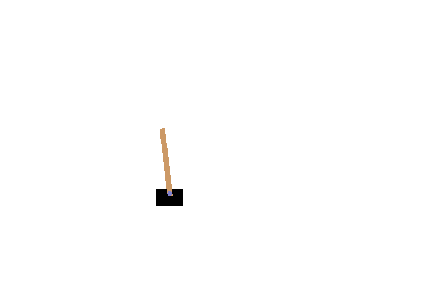
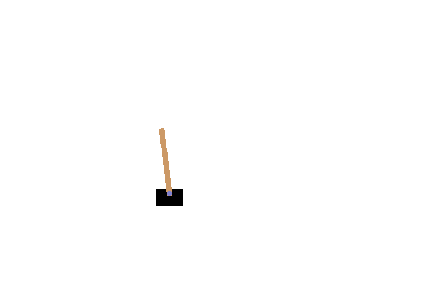
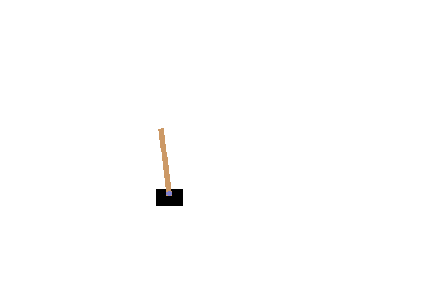
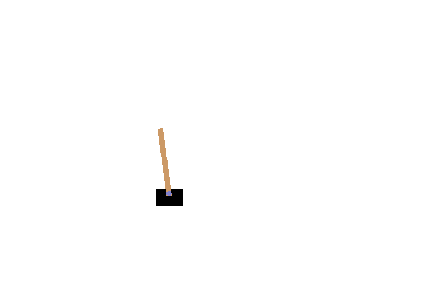
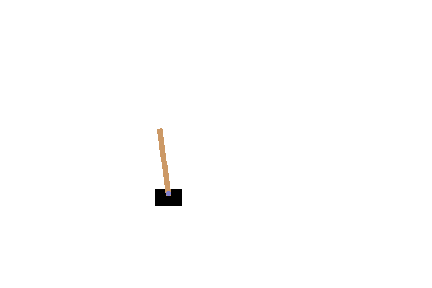
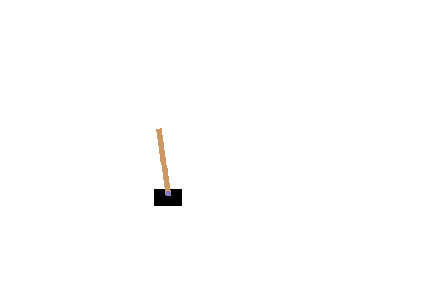
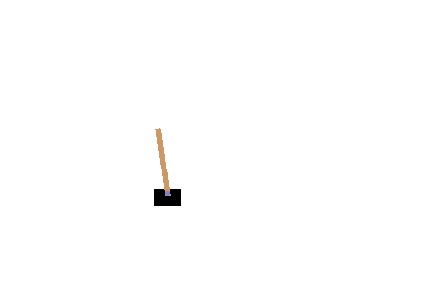
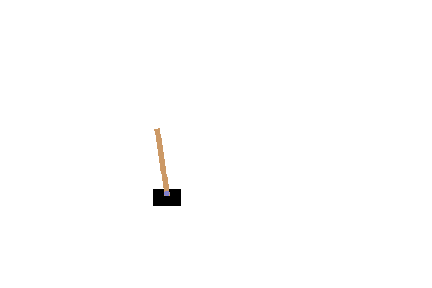
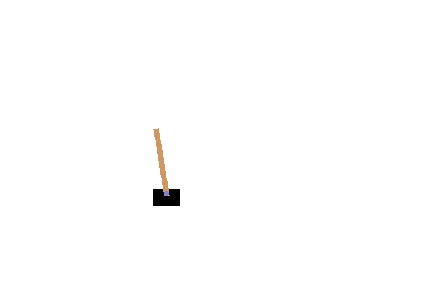
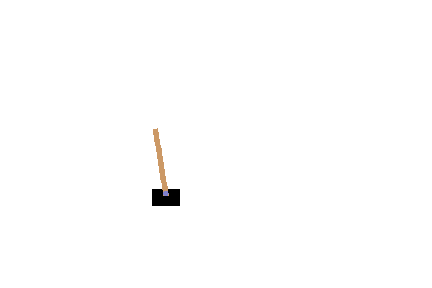
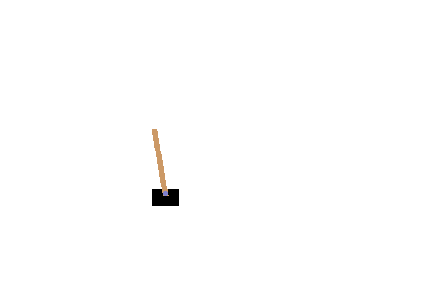
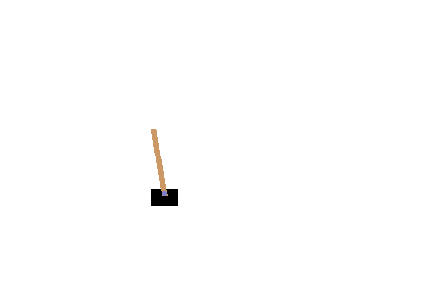
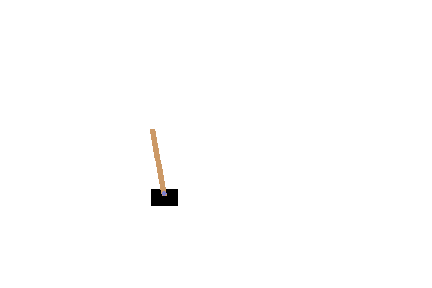
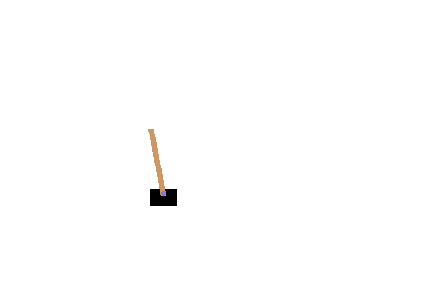
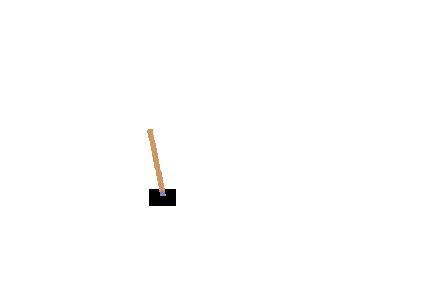
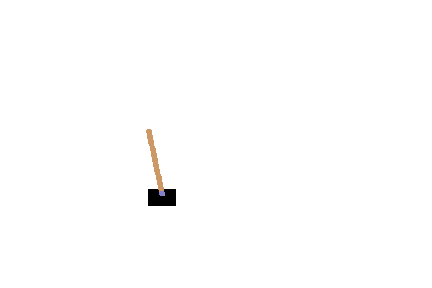
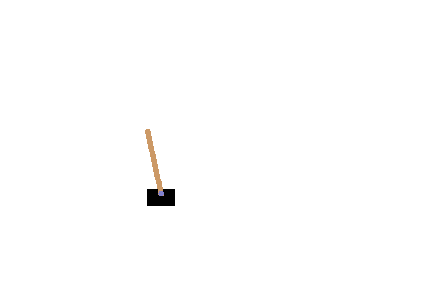

In [8]:
show_frameset(19)